# Climatology
Climtological values are simply long term averages. What do I mean by long term? When is it long enough? Typically 30 years is regarded as long enough. Climatological values are somtimes called "normal" values.

## Monthly climatology
You can create a long term mean for each month and call it "monthly climatolgies." This then defines a "typical" January, February, March, etc. 

## Deseasonalized time series 
You can also remove this monthly climatology from a time series and call it the "deseasonalized time series." When you subtract out the climatology you are left with the residual values or anomalies. Peter feeds these into his network with the idea that this will help capture high frequency variability in $pCO_2$

## Xarray makes this super simple!
This notebook uses xarray to calculate monthly climatolgies and deseasonalized time series. The deseasonalized component could be a useful feature in a neural network. 

In [2]:
%matplotlib inline
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean as cm

/Users/gloege/anaconda3/envs/cartopy/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [8]:
class SpatialMap(object):
    """
    Spatial Map
    Plot data on a world map centerted at 157.5 deg
    * set_ticks
    * set_title
    * set_cbar_title
    """

    def __init__(self, data, lon=np.arange(0.5,360,1), lat=np.arange(-89.5,90,1), 
                 fig=None, rect=111, vrange = [0, 1],  
                 cmap=cm.cm.balance, 
                 colorbar=True, ncolors=101):
        ''' spatial_map()'''
    
        ### Setup figure and axes
        if fig is None:
            fig = plt.figure(figsize=(8.5,11))
        
        ### Setup axes
        self.ax = fig.add_subplot(rect, projection=ccrs.Robinson(central_longitude=-157.5))
        fig.add_subplot(self.ax)
        
        ### Latitude and longitude
        #self.lon=np.arange(0.5,360,1)
        #self.lat=np.arange(-89.5,90,1)
        
        #self.lon=ds['xlon']
        #self.lat=ds['ylat']
        self.lon = lon
        self.lat = lat
        
        ### colorbar
        self.transform = ccrs.PlateCarree(central_longitude=0)
        self.bounds = np.linspace(vrange[0], vrange[1], ncolors)
        self.norm = mpl.colors.BoundaryNorm(self.bounds, cmap.N)
        
        ### land mask
        self.ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '110m', 
                                                    edgecolor='face', 
                                                    facecolor=[0.4, 0.4, 0.4]))
        self.ax.coastlines(facecolor=[0.4, 0.4, 0.4])
        
        ### Add data to map
        sub = self.ax.pcolormesh(self.lon, self.lat, data,
                                    norm=self.norm,
                                    transform=self.transform,
                                    cmap = cmap,
                                    vmin = vrange[0],
                                    vmax = vrange[1])

        ### Colorbar
        if colorbar is True:
            self.cbar = plt.colorbar(sub, orientation="horizontal", pad=0.01, shrink=0.8)
            self.cbar.ax.tick_params(labelsize=14)
    
    ### Class methods
    def set_ticks(self, tmin, tmax, dt, *args, **kwargs):
        self.cbar.set_ticks(np.arange(tmin, tmax+dt, dt))
        
    def set_title(self, title, *args, **kwargs):
        self.ax.set_title(title, fontsize=16, **kwargs)
        
    def set_cbar_title(self, title, *args, **kwargs):
        self.cbar.set_label(title,fontsize=16)

# Load data

In [19]:
### Directory to store data
data_dir='/Users/gloege/Documents/Projects/ocean-co2-absorption/data/raw/member_001'

### Load in pCO2 from model
ds_sst = xr.open_dataset(f'{data_dir}/SST_2D_mon_CESM001_1x1_198201-201701.nc')

### Look at data
ds_sst

<xarray.Dataset>
Dimensions:     (bnds: 2, time: 421, xlon: 360, ylat: 180)
Coordinates:
  * xlon        (xlon) float64 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 ...
  * ylat        (ylat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 -84.5 -83.5 ...
  * time        (time) datetime64[ns] 1982-01-16T12:00:00 1982-02-15 ...
Dimensions without coordinates: bnds
Data variables:
    SST_socat   (time, ylat, xlon) float64 ...
    xlon_bnds   (xlon, bnds) float64 ...
    ylat_bnds   (ylat, bnds) float64 ...
    time_bnds   (time, bnds) float64 ...
    SST         (time, ylat, xlon) float32 ...
    socat_mask  (time, ylat, xlon) float64 ...
    tmnth       (time) datetime64[ns] ...
Attributes:
    CDI:                        Climate Data Interface version 1.7.2 (http://...
    source:                     CCSM POP2, the CCSM Ocean Component
    Conventions:                CF-1.0; http://www.cgd.ucar.edu/cms/eaton/net...
    title:                      b.e11.B20TRC5CNBDRD.f09_g16.001
    contents:   

# Northern hemisphere average ocean temperature
If you squint, it looks like the temperature is increasing over time. Let's remove the periodic seasonal cycle

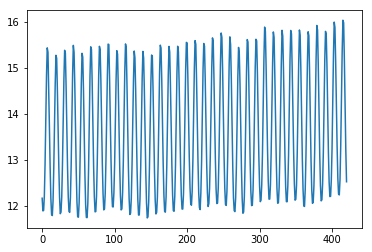

In [46]:
plt.plot(ds_sst['SST'].where(ds_sst['ylat']>0).mean(['xlon', 'ylat']))

# 1. Calculate monthly climatolgy
It's a one-liner! So pythonic!

### Caveats
Your time coordinate has to be a dtype of `datetime64` 

In [20]:
ds_sst_clim = ds_sst.groupby('time.month').mean('time')
ds_sst_clim

<xarray.Dataset>
Dimensions:     (bnds: 2, month: 12, xlon: 360, ylat: 180)
Coordinates:
  * xlon        (xlon) float64 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 ...
  * ylat        (ylat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 -84.5 -83.5 ...
  * month       (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: bnds
Data variables:
    SST_socat   (month, ylat, xlon) float64 nan nan nan nan nan nan nan nan ...
    xlon_bnds   (month, xlon, bnds) float64 0.0 1.0 1.0 2.0 2.0 3.0 3.0 4.0 ...
    ylat_bnds   (month, ylat, bnds) float64 -90.0 -89.0 -89.0 -88.0 -88.0 ...
    time_bnds   (month, bnds) float64 7.298e+05 7.298e+05 7.297e+05 ...
    SST         (month, ylat, xlon) float32 nan nan nan nan nan nan nan nan ...
    socat_mask  (month, ylat, xlon) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...

# Hemisphere seasonal cycle

Oh, that's interesting, the summer maximum is higher in the southern hemisphere. 

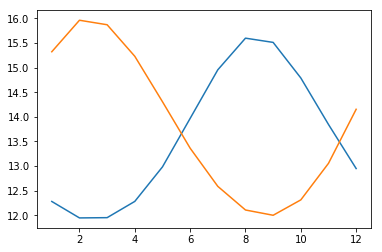

In [37]:
plt.plot(ds_sst_clim['month'], ds_sst_clim['SST'].where(ds_sst_clim['ylat']>0).mean(['xlon', 'ylat']))
plt.plot(ds_sst_clim['month'], ds_sst_clim['SST'].where(ds_sst_clim['ylat']<0).mean(['xlon', 'ylat']))

# Deseasonalized component

In [42]:
ds_sst_deseasonalized = ds_sst['SST'].groupby('time.month') - ds_sst_clim['SST']

## Now we can see an increase of about 0.5 degC over this period

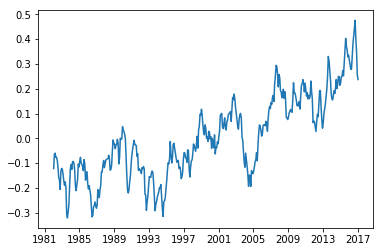

In [48]:
plt.plot(ds_sst_deseasonalized['time'],
         ds_sst_deseasonalized.where(ds_sst_deseasonalized['ylat']>0).mean(['xlon', 'ylat']))